In [4]:
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
%matplotlib inline

# figure size shit
textwidth=6.50127
fig_width = textwidth/2
golden_mean = (math.sqrt(5)-1.0)/2.0
fig_height = fig_width*golden_mean

datapath = "Z:/hcs/data/ipeds/"
namepath = "Z:/hcs/data/ipeds/cip_edit"
#datapath = "/Users/tarasullivan/Google Drive File Stream/My Drive/research/hcs/data/ipeds/"
#namepath = "/Users/tarasullivan/Google Drive File Stream/My Drive/research/hcs/data/ipeds/cip_edit"

Create dictionaries for 2-digit and 4-digit CIP codes

In [5]:
from ipeds_dict import cip2labels, cip2labels_short, cip4labels_df

Read in raw time-series data. Make basic edits. 

In [6]:
from ipeds_df import df, df2, df4

Number of Bachelor's degrees by men and women

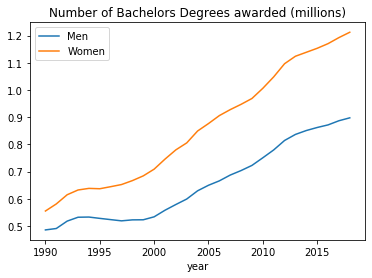

In [7]:
fig = plt.figure()
ax = plt.axes()

df.groupby(['year']).aggregate('sum').transform(lambda x: x/1e6).plot(ax=ax)

ax.set_title('Number of Bachelors Degrees awarded (millions)')

label_dict = {'ctotalm' : 'Men', 'ctotalw' : 'Women'}
handles, labels_list = ax.get_legend_handles_labels()
ax.legend(list(map(label_dict.get, labels_list)))

Totals of 2-digit CIP codes for men and women

In [8]:
# list of top 20 2-digit cip codes
cip2_2018 = df2.groupby(['year','cip2']).aggregate('sum').loc[2018]

# save values of top 20 index
top20 = cip2_2018.sum(axis=1).sort_values(ascending=False).iloc[:20].index.values
top12 = cip2_2018.sum(axis=1).sort_values(ascending=False).iloc[:12].index.values

In [9]:
# top 12 cip codes, aggregated
cip2df = df2[df2['cip2'].isin(top12)].groupby(['year','cip2']).aggregate('sum').unstack()

# switch order of columns
cip2df.columns = cip2df.columns.swaplevel(0,1)
cip2df.sort_index(axis=1, level=0, inplace = True)

Text(0.5, 1.1, "Bachelor's degrees awarded at postsecondary institutions (thousands)")

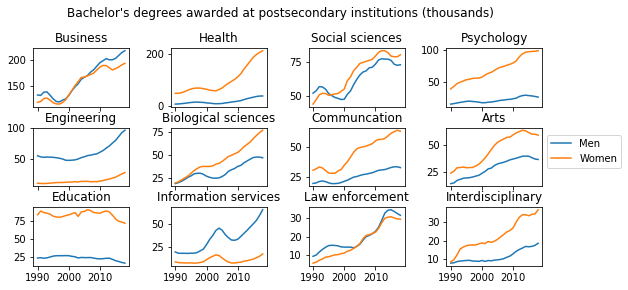

In [10]:
fig, ax = plt.subplots(3,4,sharex='col')

# Figure size shit 

fig.set_size_inches(2.4*fig_width,1.8*fig_height)

fig.tight_layout() 

for i in range(3):
    for j in range(4):
        k = i*4+j
        ax[i,j].plot(cip2df[top12[k]].transform(lambda x: x/1e3))
        ax[i,j].set_title(cip2labels_short[top12[k]])

# create legend (bug necessitates awkward language)
ax[1,3].legend(list(map(label_dict.get, cip2df[top12[0]].columns.to_list())), 
               loc='center left',bbox_to_anchor=(1,.6))


fig.suptitle('Bachelor\'s degrees awarded at postsecondary institutions (thousands)',x=0.5,y=1.1)

In [11]:
# reshape dataframe
cip2rate = cip2df.swaplevel(axis=1).stack()
cip2rate['rate'] = cip2rate['ctotalw']/cip2rate['ctotalm']
cip2rate = cip2rate['rate'].unstack()

Text(0.5, 1.1, 'Ratio of women to men')

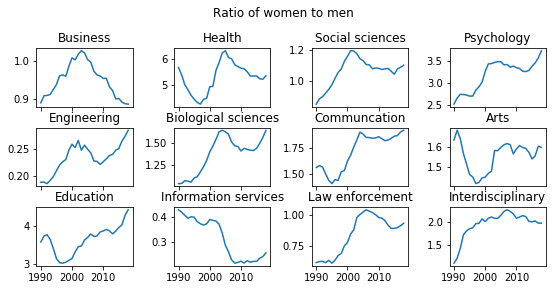

In [12]:
fig, ax = plt.subplots(3,4,sharex='col')

# Figure size shit 

fig.set_size_inches(2.4*fig_width,1.8*fig_height)

fig.tight_layout() 

for i in range(3):
    for j in range(4):
        k = i*4+j
        ax[i,j].plot(cip2rate[top12[k]])
        ax[i,j].set_title(cip2labels_short[top12[k]])

fig.suptitle('Ratio of women to men',x=0.5,y=1.1)

### Recreate Figure 1 from Sloane, Hurst, and Black (2020)

Link to paper: https://bfi.uchicago.edu/wp-content/uploads/BFI_WP_2019121.pdf

Text(0.5, 1.0, 'Historically female dominated majors')

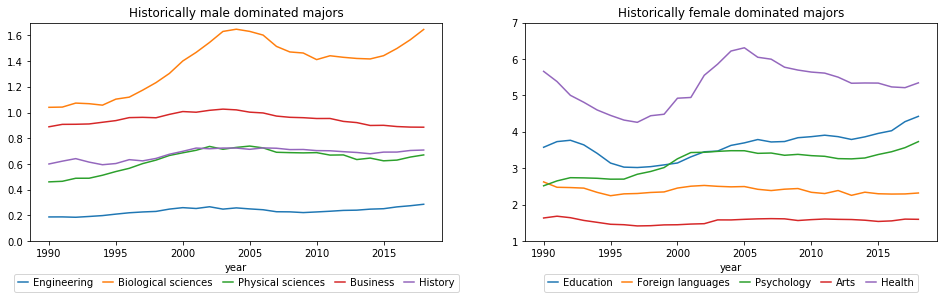

In [13]:
fig, ax = plt.subplots(1,2,sharex='col')
fig.set_size_inches(5*fig_width,2*fig_height)

# biology, business, history, physical sciences, engineering
male_dom = ['26','52','54','40','14']
# biology, business, history, physical sciences, engineering
female_dom = ['51','50','42','16','13']

# top 12 cip codes, aggregated
cip2df = df2[df2['cip2'].isin(male_dom)].groupby(['year','cip2']).aggregate('sum').unstack()

# switch order of columns
cip2df.columns = cip2df.columns.swaplevel(0,1)
cip2df.sort_index(axis=1, level=0, inplace = True)

# reshape dataframe
cip2rate = cip2df.swaplevel(axis=1).stack()
cip2rate['rate'] = cip2rate['ctotalw']/cip2rate['ctotalm']
cip2rate = cip2rate['rate'].unstack()

cip2rate.plot(ax=ax[0])

ax[0].set_ylim(0,1.7)

handles, labels = ax[0].get_legend_handles_labels()
txt_labels = list(map(cip2labels_short.get, labels))
ax[0].legend(handles, txt_labels,ncol=5,
          loc='upper center',bbox_to_anchor=(.5,-.15),borderaxespad=0,
          handlelength=1,
          handletextpad=.5,
          columnspacing=1
         )
ax[0].set_title('Historically male dominated majors')

# top 12 cip codes, aggregated
cip2df = df2[df2['cip2'].isin(female_dom)].groupby(['year','cip2']).aggregate('sum').unstack()

# switch order of columns
cip2df.columns = cip2df.columns.swaplevel(0,1)
cip2df.sort_index(axis=1, level=0, inplace = True)

# reshape dataframe
cip2rate = cip2df.swaplevel(axis=1).stack()
cip2rate['rate'] = cip2rate['ctotalw']/cip2rate['ctotalm']
cip2rate = cip2rate['rate'].unstack()

cip2rate.plot(ax=ax[1])

ax[1].set_ylim(1,7)

handles, labels = ax[1].get_legend_handles_labels()
txt_labels = list(map(cip2labels_short.get, labels))
ax[1].legend(handles, txt_labels,ncol=5,
          loc='upper center',bbox_to_anchor=(.5,-.15),borderaxespad=0,
          handlelength=1,
          handletextpad=.5,
          columnspacing=1
         )

ax[1].set_title('Historically female dominated majors')

### Bachelor's degree completions (in thousands) by 4-digit CIP code

In [14]:
def cipgraph(cip,cipdict={},shareyflag=True,cipnum=False,rategraph=True,dropcip=True):
    '''Return a figure with a stacked area graph for particular CIP codes
    '''
    
    # if relevant, pass dictionary
    if len(cipdict)!=0:
        #Invert map
        cipmap = {}
        for key, value in cipdict.items():
            for cipcode4 in value:
                cipmap.update({cipcode4 : key})

        # create dataframe for all cip4 that replaces with ciptitle if not defined
        cip_desc = cip4labels_df.loc[cip].reset_index()
        # create variable 
        cip_desc['group'] = cip_desc['cip4'].map(cipmap)
        if cipnum == False:
            cip_desc['group'] = cip_desc.group.fillna(cip_desc['ciptitle2010'])
        else:
            cip_desc['group'] = cip_desc.group.fillna(cip_desc['cip4'] + ': ' + cip_desc['ciptitle2010'])
        # drop title column
        cip_desc = cip_desc.drop(['ciptitle2010'],axis=1)
        # create as a dictionary that can be mapped 
        cip_mapdict = cip_desc.set_index('cip4').to_dict()['group']
    
    # Create dataset 
    # copy relevant portion of the dataset
    cipdf = df4.loc[df4['cip2']==cip].copy()
    # create group variable
    if len(cipdict)!=0:
        groupvar = 'group'
        cipdf['group'] = cipdf['cip4'].map(cip_mapdict)
    else:
        groupvar = 'cip4'
    # aggregate by the group
    cipdf = cipdf.groupby(['year',groupvar]).aggregate('sum').unstack()
    # find the maximum value in dataframe; add 5% to be consistent with matplotlib
    maxval = (cipdf.transform(lambda x: x/1e3).stack().groupby(['year']).aggregate('sum').values.max())*1.05
    
    # order graph elements; first find largest groups
    ciplist = (cipdf.sum().groupby(groupvar).aggregate('sum')/cipdf.sum().sum()).sort_values(ascending=False)
    # re-order columns
    cipdf = cipdf.reindex(list(ciplist.index.values),axis=1,level=1)
    
    # rate data
    if rategraph:
        # keep only those cip that you want to graph
        if dropcip == True:
            keepcip = list(ciplist[ciplist.ge(.03)].index.values)
        else:
            keepcip = list(ciplist.index.values)
        # create dataset of rates
        ciprate_df = cipdf.stack(dropna=False)
        ciprate_df = ciprate_df.loc[pd.IndexSlice[:,keepcip],:]
        ciprate_df['rate'] = ciprate_df['ctotalw']/ciprate_df['ctotalm']
        ciprate_df = ciprate_df['rate'].unstack()

    # Create figure
    fig, ax = plt.subplots(1,2,sharey=shareyflag)

    #fig.set_size_inches(3*fig_width,3*fig_height)

    cipdf['ctotalw'].transform(lambda x: x/1e3).plot.area(ax=ax[0],legend=None)
    cipdf['ctotalm'].transform(lambda x: x/1e3).plot.area(ax=ax[1],legend=None)

    ax[0].set_title('Women')
    ax[1].set_title('Men')
    
    if shareyflag == True:
        ax[0].set_ylim((0, maxval))
    
    fig.suptitle(cip2labels[cip])

    handles, labels = ax[0].get_legend_handles_labels()
    if len(cipdict)!=0:
        txt_labels = labels
    else:
        txt_labels = list(map(cip4labels_df.loc[cip].to_dict()['ciptitle2010'].get, labels))
    fig.legend(handles[::-1], txt_labels[::-1], 
               loc='center left',bbox_to_anchor=(.9,.6),borderaxespad=0)
    
    plt.show()
    
    
    # Create second figure showing rates
    if rategraph == True:
        fig, ax = plt.subplots(1,1)

        ciprate_df.plot(ax=ax)

        ax.get_legend().remove()
        
        fig.suptitle('Ratio of women to men')

        plt.show()

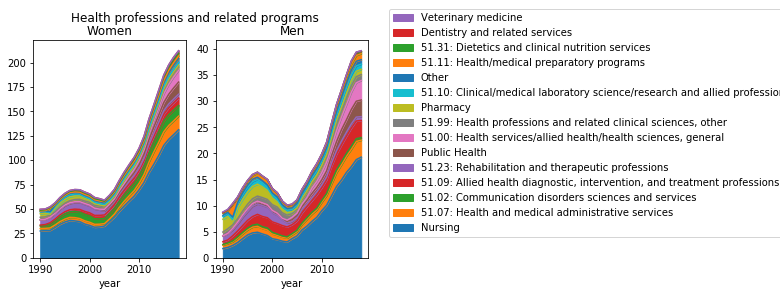

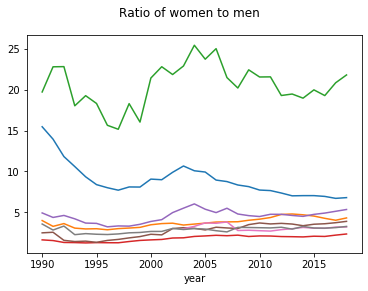

In [15]:
# create mapping that you want to use 
cip51dict = {'Nursing' : ['51.38', '51.39'],
              'Dentistry and related services' : ['51.04', '51.05', '51.06'],
              'Veterinary medicine' : ['51.24', '51.25'],
              'Pharmacy' : ['51.20'],
              'Public Health' : ['51.22'],
              'Other' : [
#                          '51.02',
                         '51.08',
#                          '51.04', '51.05', '51.06',
#                          '51.11',
                         '51.12',
                         '51.14',
                         '51.15','51.18',
#                          '51.24', '51.25',
                         '51.26',
                         '51.27',
#                          '51.31',
                         '51.32',
                         '51.33',
                         '51.34',
                         '51.35',
                         '51.36',
                         '51.37',
#                          '51.99'
                         ]}
# 51.11 is weird!
cipgraph('51',cip51dict,cipnum=True,shareyflag=False)

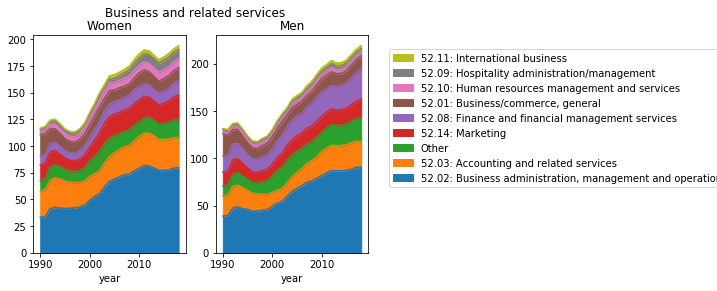

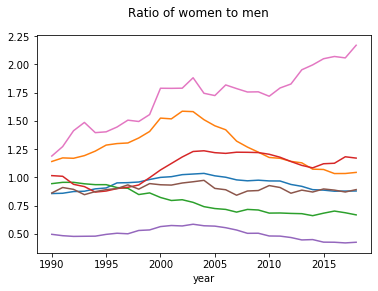

In [16]:
cip52dict = {'Other' : ['52.04','52.05','52.06','52.07',
                        '52.12','52.13','52.15','52.16','52.17','52.18','52.19','52.20','52.21','52.99']}
cipgraph('52',cip52dict,False,True)

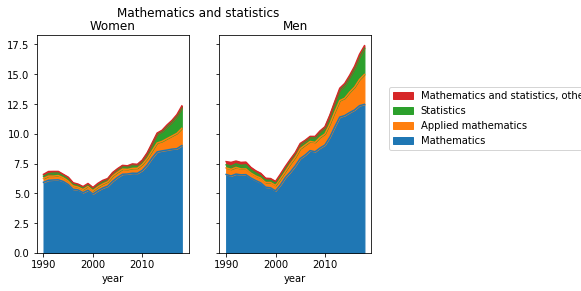

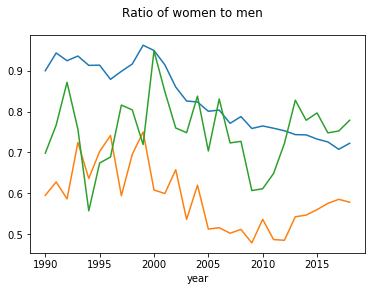

In [17]:
cipgraph('27')

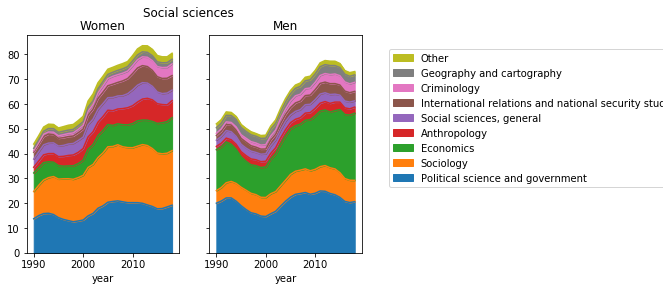

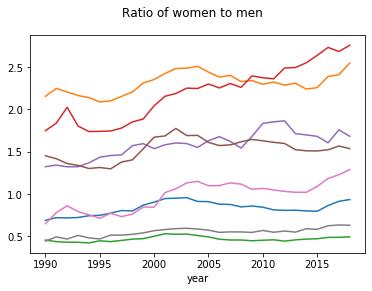

In [18]:
cip45dict = {'Other' : ['45.03','45.05','45.12','45.13','45.14','45.99']}
cipgraph('45',cip45dict)

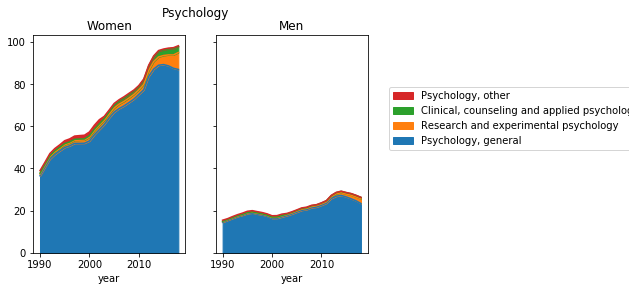

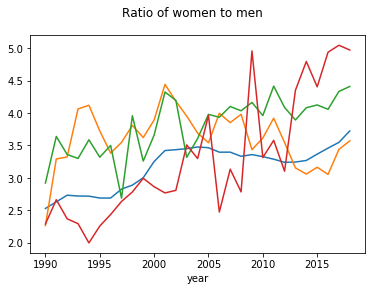

In [19]:
cipgraph('42',dropcip=False)

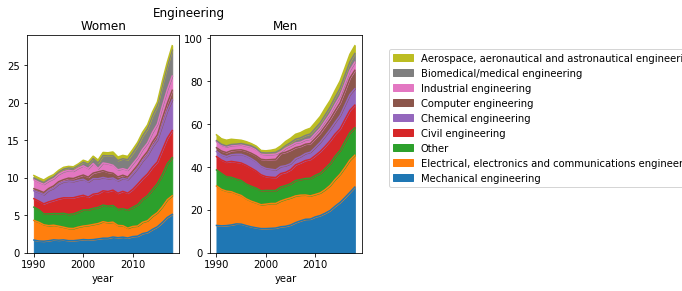

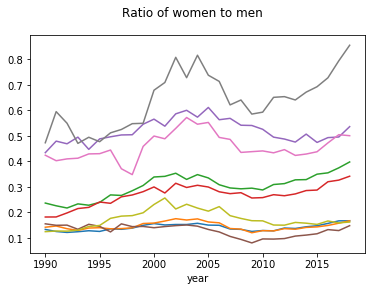

In [20]:
cip14dict = {'Other' : [
                        '14.01','14.03','14.04','14.06',
                        '14.11','14.12','14.13','14.14','14.18',
                        '14.20','14.21','14.22','14.23','14.24','14.25','14.27','14.28',
                        '14.32','14.33','14.34','14.36','14.37','14.38','14.39',
                        '14.40','14.41','14.42', '14.43','14.44','14.45',
                        '14.99'
                        ]}

cipgraph('14',cip14dict,shareyflag=False)

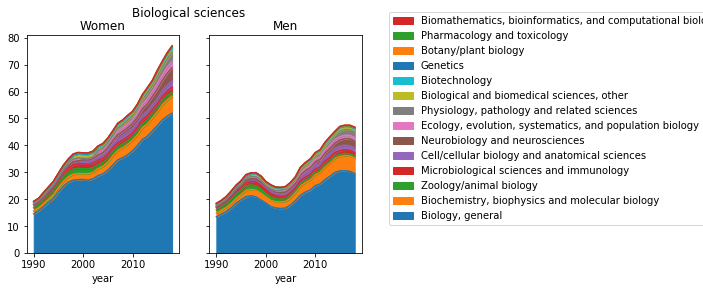

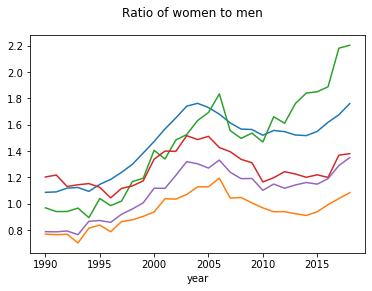

In [21]:
cipgraph('26')

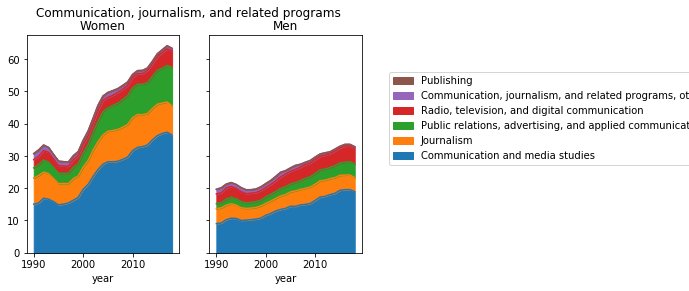

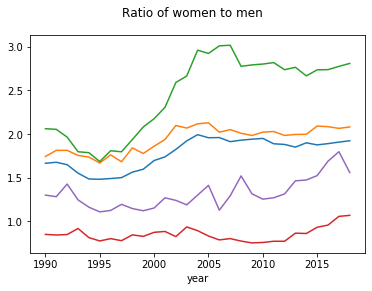

In [22]:
cipgraph('09')

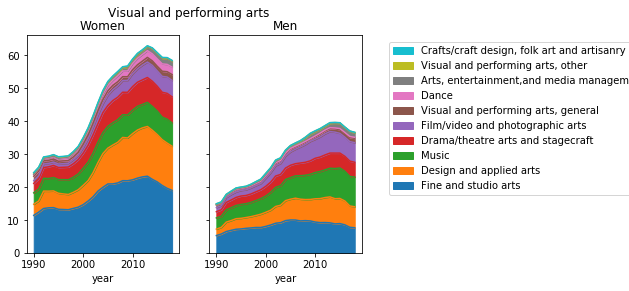

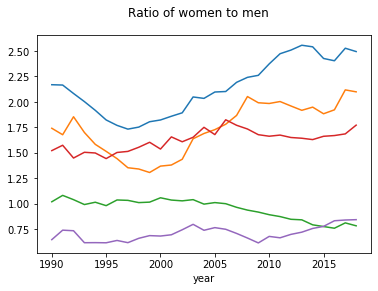

In [23]:
cipgraph('50')

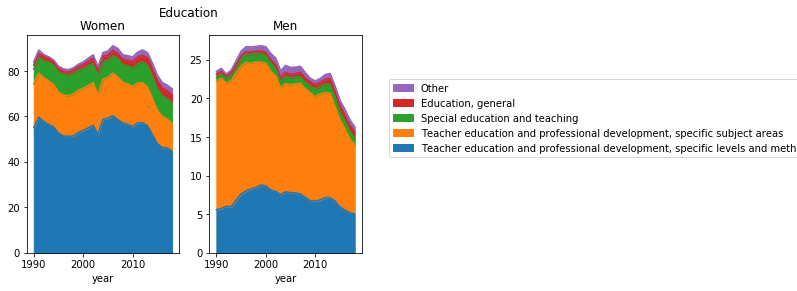

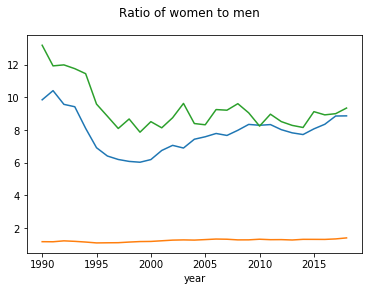

In [24]:
cip13dict = {'Other' : ['13.02','13.03','13.04','13.05','13.06','13.07','13.09','13.11','13.14','13.15','13.99']}
cipgraph('13',cip13dict,shareyflag=False)

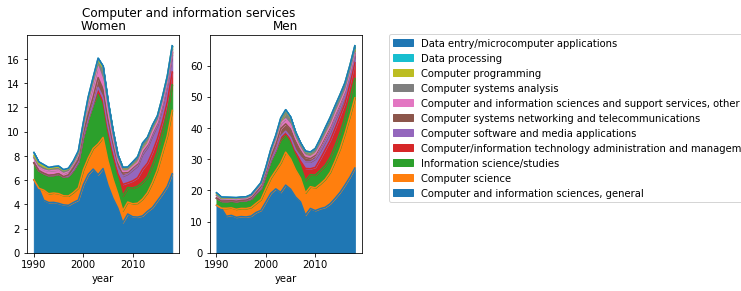

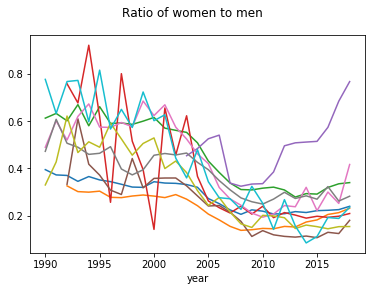

In [25]:
cipgraph('11',shareyflag=False,dropcip=False)

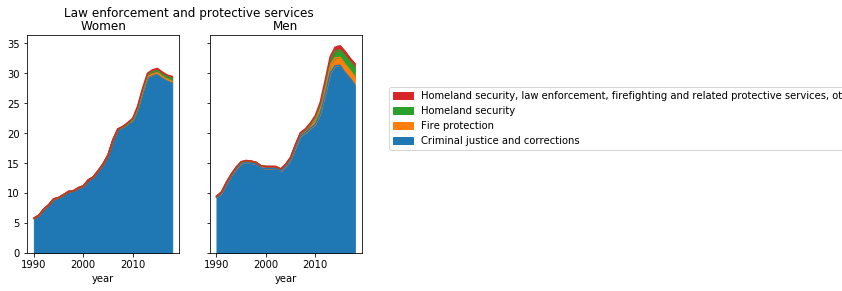

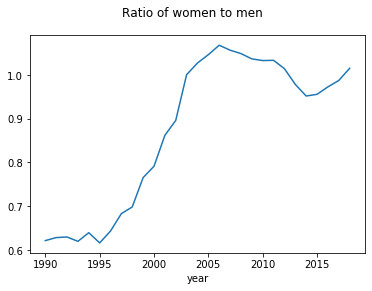

In [26]:
cipgraph('43')

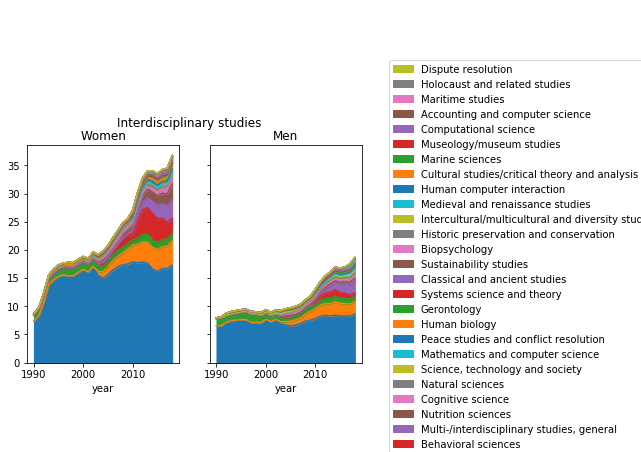

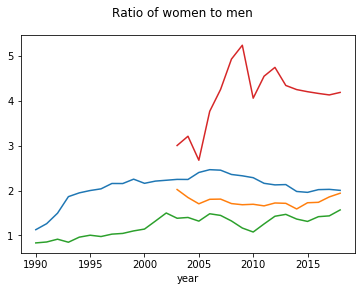

In [27]:
cipgraph('30')

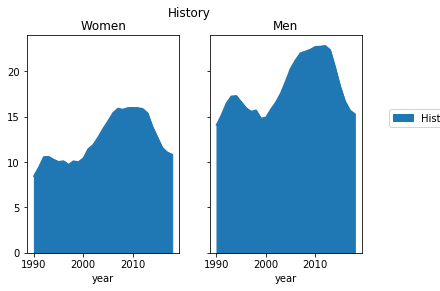

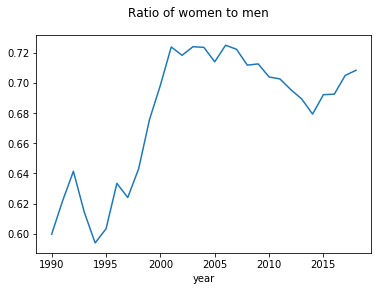

In [28]:
cipgraph('54')

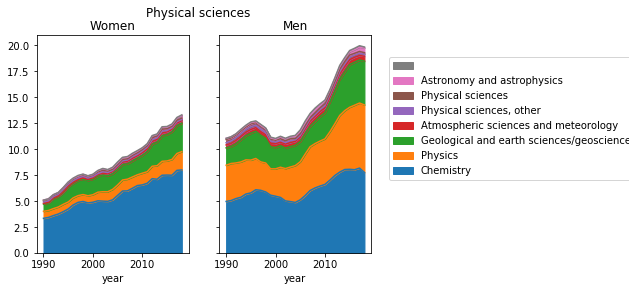

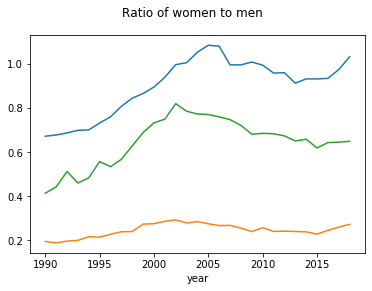

In [29]:
cipgraph('40')

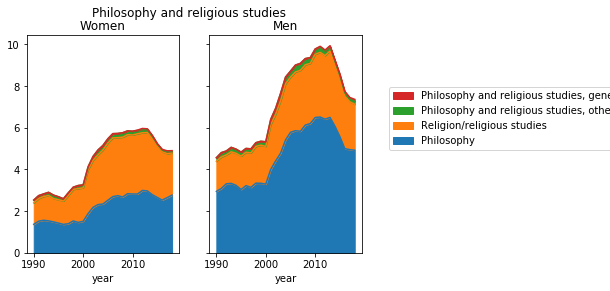

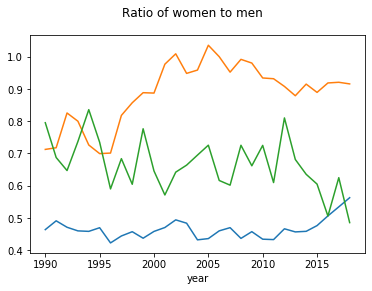

In [35]:
cipgraph('38')

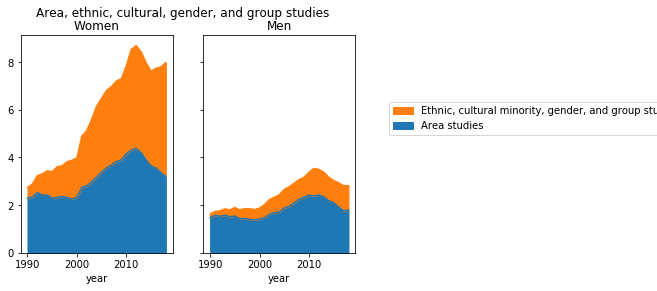

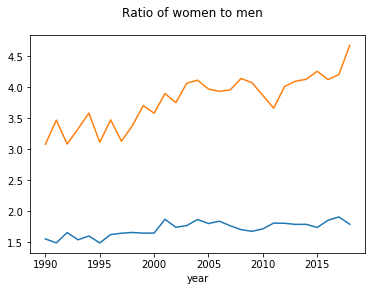

In [37]:
cipgraph('05')

Code I used to make the above graphs, specifically for Health

In [30]:
# copy dataset; convert to thousands
cip51 = df4[(df4['cip2']=='51')].copy()
cip51 = cip51[(cip51['cip4'] != '51.38') & (cip51['cip4'] != '51.39')]
# create group variable
# aggregate by the group
cip51 = cip51.groupby(['year', 'cip4']).aggregate('sum').unstack()
# convert to thousands
# cip51 = cip51/1e3

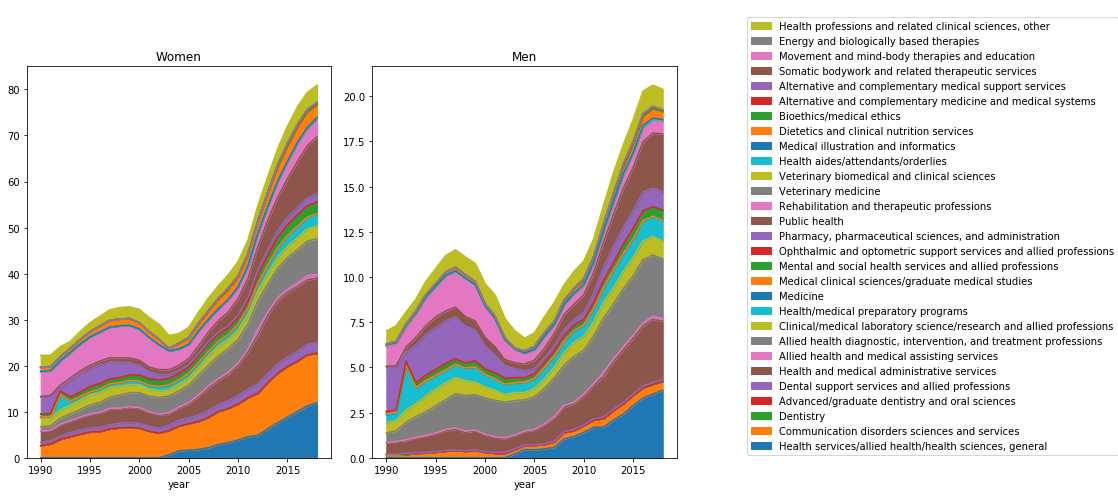

In [31]:
fig, ax = plt.subplots(1,2)

# Figure size shit 
fig.set_size_inches(3*fig_width,3*fig_height)

fig.tight_layout() 

cip51['ctotalw'].transform(lambda x: x/1e3).plot.area(ax=ax[0],legend=None)
cip51['ctotalm'].transform(lambda x: x/1e3).plot.area(ax=ax[1],legend=None)

ax[0].set_title('Women')
ax[1].set_title('Men')

#ax[0].legend(None)
handles, labels = ax[1].get_legend_handles_labels()
txt_labels = list(map(cip4labels_df.loc['51'].to_dict()['ciptitle2010'].get, labels))
fig.legend(handles[::-1], txt_labels[::-1], loc='center right',bbox_to_anchor=(1.6, .6))

In [32]:
cip51rate = cip51.stack(dropna=False)
cip51rate['rate'] = cip51rate['ctotalw']/cip51rate['ctotalm']
cip51rate = cip51rate['rate'].unstack()

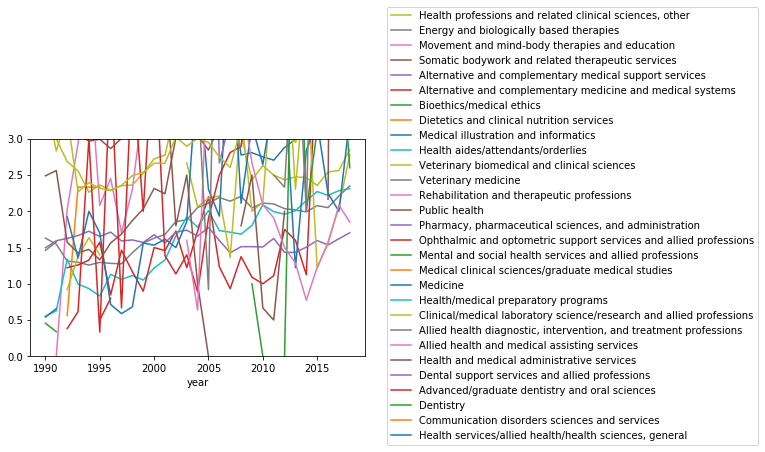

In [33]:
fig = plt.figure()
ax = plt.axes()

# Figure size shit 
# fig.set_size_inches(3*fig_width,3*fig_height)

# fig.tight_layout() 

cip51rate.plot(ax=ax)

ax.set_ylim((0,3))

handles, labels = ax.get_legend_handles_labels()
txt_labels = list(map(cip4labels_df.loc['51'].to_dict()['ciptitle2010'].get, labels))
ax.legend(handles[::-1], txt_labels[::-1], loc='center left',bbox_to_anchor=(1.05, .6))